In [31]:
import pandas as pd
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import heapq
from matplotlib import pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score, classification_report
import joblib
from sklearn.tree import export_graphviz
import pydot
import imblearn
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.metrics import cohen_kappa_score

import sys
import os.path


In [32]:
base = "/mnt/nfs/scratch1/hshukla/prediction_results/"
output_folder = "/mnt/nfs/scratch1/hshukla/prediction_results/"

file_base = "{}_{}_{}_{}_{}.csv"
ws = 7
start_year = 2012
end_year = 2015
pred_year = 2016
RANDOM_STATE = 5
exper_num = 1

# original_stdout = sys.stdout
# logfile_path = 'lda{}_experiment_{}.txt'.format(ws, exper_num)
# if not os.path.exists(logfile_path):
#     file = open(logfile_path, 'a+')
#     file.write("Init File\n")
#     file.close()
# out_file = open(logfile_path, 'a+')
# sys.stdout = out_file

In [33]:
train_df = pd.read_csv(base + file_base.format("training", start_year, end_year, pred_year, ws))
test_df = pd.read_csv(base + file_base.format("testing", start_year, end_year, pred_year, ws))

In [4]:
display(train_df.columns)
display(test_df.columns)

Index(['Unnamed: 0', 'index', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'cik',
       'ticker_x', 'filing_date', 'item1a_risk', 'item7_mda', 'year_x',
       'filing_year_x', 'perm_id', 'ticker_y', 'year_y', 'company_name',
       'is_dividend_payer', 'dps_change', 'is_dps_cut', 'z_environmental',
       'd_environmental', 'sector', 'filing_year_y', 'risk_topic_0',
       'risk_topic_1', 'risk_topic_2', 'risk_topic_3', 'risk_topic_4',
       'risk_topic_5', 'risk_topic_6', 'risk_topic_7', 'risk_topic_8',
       'risk_topic_9', 'risk_topic_10', 'risk_topic_11', 'risk_topic_12',
       'risk_topic_13', 'risk_topic_14', 'risk_topic_15', 'risk_topic_16',
       'risk_topic_17', 'risk_topic_18', 'risk_topic_19', 'risk_topic_20',
       'risk_topic_21', 'risk_topic_22', 'risk_topic_23', 'risk_topic_24',
       'risk_topic_25', 'risk_topic_26', 'risk_topic_27', 'risk_topic_28',
       'risk_topic_29', 'mda_topic_0', 'mda_topic_1', 'mda_topic_2',
       'mda_topic_3', 'mda_topic_4', 'mda_topic_5', 'md

Index(['Unnamed: 0', 'index', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'cik',
       'ticker_x', 'filing_date', 'item1a_risk', 'item7_mda', 'year_x',
       'filing_year_x', 'perm_id', 'ticker_y', 'year_y', 'company_name',
       'is_dividend_payer', 'dps_change', 'is_dps_cut', 'z_environmental',
       'd_environmental', 'sector', 'filing_year_y', 'dps_cut_prediction',
       'risk_topic_0', 'risk_topic_1', 'risk_topic_2', 'risk_topic_3',
       'risk_topic_4', 'risk_topic_5', 'risk_topic_6', 'risk_topic_7',
       'risk_topic_8', 'risk_topic_9', 'risk_topic_10', 'risk_topic_11',
       'risk_topic_12', 'risk_topic_13', 'risk_topic_14', 'risk_topic_15',
       'risk_topic_16', 'risk_topic_17', 'risk_topic_18', 'risk_topic_19',
       'risk_topic_20', 'risk_topic_21', 'risk_topic_22', 'risk_topic_23',
       'risk_topic_24', 'risk_topic_25', 'risk_topic_26', 'risk_topic_27',
       'risk_topic_28', 'risk_topic_29', 'mda_topic_0', 'mda_topic_1',
       'mda_topic_2', 'mda_topic_3', 'mda_topic_

In [34]:
train_documents_weights = train_df.loc[:,"risk_topic_0":].to_numpy().tolist()
train_documents_labels = train_df.loc[:,"is_dps_cut"].to_list()
test_documents_weights = test_df.loc[:,"risk_topic_0":].to_numpy().tolist()
y_actual = test_df.loc[:,"is_dps_cut"].to_list()

In [35]:
counter = Counter(train_documents_labels)
total = float(sum(list(counter.values())))
class_weights = {0: total/float(counter.get(0)), 1: total/float(counter.get(1))}

display(counter)
display(total)
display(class_weights)

Counter({0: 4768, 1: 387})

5155.0

{0: 1.0811661073825503, 1: 13.320413436692506}

In [36]:
rf = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1, max_depth=5, class_weight=class_weights)
rf.fit(X=train_documents_weights, y=train_documents_labels)
y_pred_test_prob = rf.predict_proba(test_documents_weights)

In [37]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

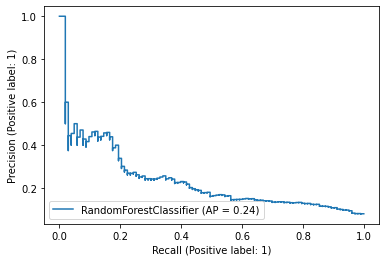

In [38]:
plot_precision_recall_curve(rf, test_documents_weights, y_actual)
plt.savefig("rf_ws{}_5_classweights_prc.png".format(ws))

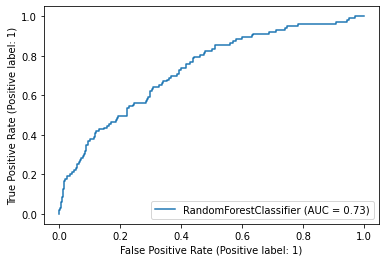

In [39]:
from sklearn.metrics import plot_roc_curve, roc_auc_score
plot_roc_curve(rf, test_documents_weights, y_actual)
plt.savefig("rf_ws{}_5_classweights_roc.png".format(ws))

In [7]:
def print_metrics(y_real, y_predicted):
    accuracy = accuracy_score(y_real, y_predicted)
    precision = precision_score(y_real, y_predicted)
    recall = recall_score(y_real, y_predicted)
    f1 = f1_score(y_real, y_predicted)
    print("Accuracy: {:.4f}".format(accuracy))
    print("Precision: {:.4f}".format(precision))
    print("Recall: {:.4f}".format(recall))
    print("F1-score: {:.4f}".format(f1))
    print(classification_report(y_real, y_predicted, target_names=["no_cut", "yes_cut"]))
    
    cm = confusion_matrix(y_real, y_predicted)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm.diagonal())

def train_and_validate(max_depth,samp_strat=None, class_weight=None):
    print("Max_Depth: {}".format(max_depth))
    if class_weight:
        print("Using class weighting")
        print(class_weight)
        rf = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1, max_depth=max_depth, class_weight=class_weight)
    else:
        rf = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1, max_depth=max_depth)
    
    if samp_strat:
        print("SMOTE sampling: {}".format(samp_strat))
        smote = SMOTE(sampling_strategy=samp_strat, random_state=RANDOM_STATE)
        x_vals, y_vals = smote.fit_resample(train_documents_weights, train_documents_labels)
    else:
        x_vals = train_documents_weights
        y_vals = train_documents_labels
    
    # Output class counts
    counter = Counter(y_vals)
    print(counter)
    
    # Fit the model
    rf.fit(X=x_vals, y=y_vals)
    
    # Get training metrics first
    print("- - - Train - - -")
    y_pred_train = rf.predict(x_vals)
    print_metrics(y_vals, y_pred_train)
    print()
    
    # Prediction metrics
    print("- - - Test - - -")
    y_pred_test = rf.predict(test_documents_weights)
    print("Cohen-Kappa: {:.4f}".format(cohen_kappa_score(y_actual, y_pred_test)))
    print_metrics(y_actual, y_pred_test)
    
        
    print("\n")
    print("----------------------------------------------------------------")

In [8]:
depths = [3,5,7]
sample_strategies = [.1,.3,.5,.7,1]
for depth in depths:
    for samp_strat in sample_strategies:
        train_and_validate(depth,samp_strat=samp_strat)

/home/hshukla/anaconda3/envs/harshulEnv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hshukla/anaconda3/envs/harshulEnv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hshukla/anaconda3/envs/harshulEnv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

In [9]:
for depth in depths:
    train_and_validate(depth,class_weight=class_weights)